# Gauss-Newton for XRD

In [27]:
from XRDXRFutils import GaussNewton,DataXRD,SpectraXRD,DatabaseXRD,PhaseList
from matplotlib.pyplot import xlim,ylim,xlabel,ylabel,legend,plot,fill_between,imshow,subplots,sca
from numpy import prod,array,minimum
from multiprocessing import Pool

### loading data

In [2]:
path = '/home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/'

spectra = SpectraXRD().from_file(path + 'Frame0128.dat')
spectra.opt = [-1185,1950,51]

data = DataXRD().load_h5(path + 'data.h5')
data.opt = [-1185,1950,51]

database = DatabaseXRD().read_cifs('/home/zdenek/Projects/XRDXRFutils/Database')

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][0]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]

phases = PhaseList([hydrocerussite,lazurite,cinnabar,barite,spinel,calcite])

Loading: /home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/data.h5


In [3]:
class PhaseSearch():
    def __init__(self,phases,spectra):
        self.g_list = [GaussNewton(phase,spectra) for phase in phases]
        
        for g in self.g_list:
            g.opt = self.g_list[0].opt
        
    def minimize_gamma(self,n=4):
        for g in self.g_list:
            for i in range(n):
                g.minimize_gamma()
                
    def overlap_area(self):
        return array([g.overlap_area() for g in self.g_list])
    
    def loss(self):
        return array([g.overlap_area() for g in self.g_list])
    
    def select(self):
        idx = self.overlap_area().argmax()
        selected = self.g_list[idx]
        
        return selected
    
    def theta_correction(self,n=4):
        for i in range(n):
            self.select().calibration()
            
    def search(self):
        
        self.minimize_gamma()
        self.select()

        self.theta_correction()
        self.minimize_gamma()
        
        return self

In [4]:
phase_search = PhaseSearch(phases,spectra)

phase_search.minimize_gamma()
phase_search.select()

phase_search.theta_correction()
phase_search.minimize_gamma()

In [5]:
phase_search.overlap_area()

array([43.1180073 , 19.67588471,  3.12238351, 18.89064398,  0.92449746,
        8.49055134])

Text(0, 0.5, 'relative intensity')

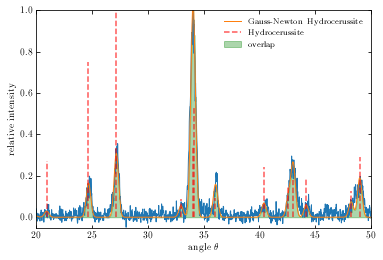

In [6]:
%matplotlib inline

g = phase_search.select()

g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
g.phase.plot('r',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,50)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

In [7]:
data2 = data.data[::2,::2,:]
data4 = data.data[::4,::4,:]

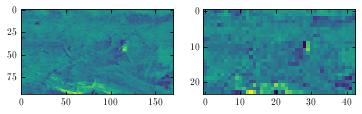

In [8]:
fig,ax = subplots(1,2)
ax[0].imshow(data.data.mean(-1))
ax[1].imshow(data4.mean(-1))

In [9]:
%%time
phase_map = []
for data in data4.reshape(-1,1280):
    spectra = spectra.from_array(data)
    phase_search = PhaseSearch(phases,spectra)
    
    phase_map += [phase_search]

CPU times: user 1.11 s, sys: 5.56 ms, total: 1.12 s
Wall time: 1.12 s


In [15]:
%%time

def f(x):
    x.search()
    return x

with Pool(48) as p:
    result = p.map(f,phase_map)

CPU times: user 1.15 s, sys: 357 ms, total: 1.5 s
Wall time: 8.16 s


Text(0, 0.5, 'relative intensity')

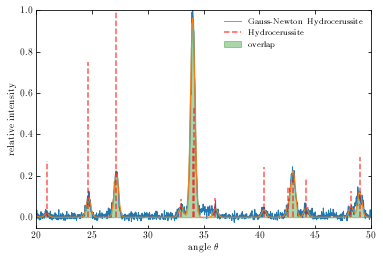

In [18]:
%matplotlib inline

g = result[201].select()

g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
g.phase.plot('r',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,50)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

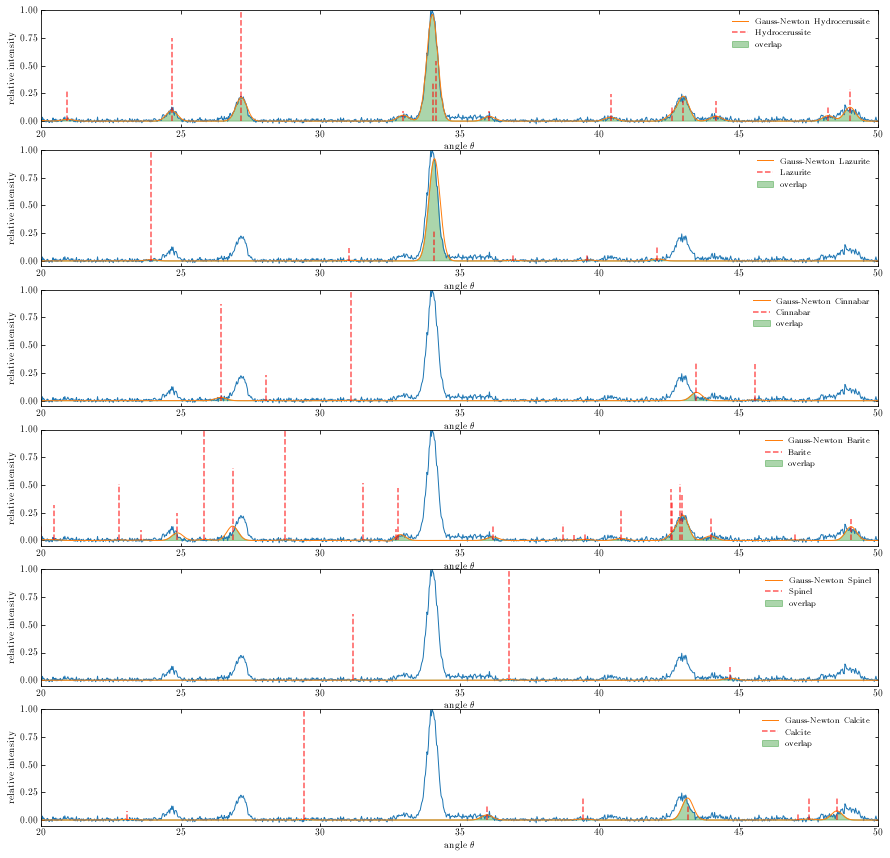

In [43]:
g_list = result[201].g_list
fig,ax = subplots(len(g_list),1,figsize=(15,15))
                  
for i,g in enumerate(g_list):
    
    sca(ax[i])
    
    g.plot_spectra(lw=1)
    g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
    g.phase.plot('r',alpha=0.66)

    fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

    legend(frameon=False)
    ylim(-0.05,1)
    xlim(20,50)
    xlabel(r'angle $\theta$')
    ylabel(r'relative intensity')